In [607]:
import os
import datetime
import pandas as pd
import geopandas as gpd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
import matplotlib.pyplot as plt
import seaborn as sns
import similarity
import predictor

plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'dejavusans',
    'font.serif': ['simsun', 'AR PL UMing CN'],
    'axes.unicode_minus': False,
})

In [509]:
class Encoder:
    def __init__(
        self,
        dialects,
        chars,
        outputs,
        emb_size=20,
        dialect_emb_size=None,
        char_emb_size=None,
        output_emb_size=None,
        hidden_layer=2,
        hidden_size=100,
        activation=tf.nn.relu,
        output_bias=False,
        l2=0
    ):
        if dialect_emb_size is None:
            dialect_emb_size = emb_size
        if char_emb_size is None:
            char_emb_size = emb_size
        if output_emb_size is None:
            output_emb_size = char_emb_size
            
        self.dialects = tf.convert_to_tensor(dialects)
        self.chars = tf.convert_to_tensor(chars)
        self.outputs = [tf.convert_to_tensor(o) for o in outputs]
        self.activation = activation
        self.output_bias = output_bias
        self.l2 = l2
        
        self.dialect_table = tf.lookup.StaticVocabularyTable(
            initializer=tf.lookup.KeyValueTensorInitializer(
                keys=dialects,
                values=tf.range(dialects.shape[0], dtype=tf.int64)
            ),
            num_oov_buckets=1
        )
        self.char_table = tf.lookup.StaticVocabularyTable(
            initializer=tf.lookup.KeyValueTensorInitializer(
                keys=chars,
                values=tf.range(chars.shape[0], dtype=tf.int64)
            ),
            num_oov_buckets=1
        )
        
        self.dialect_emb = tf.Variable(tf.random_normal_initializer()(
            shape=(self.dialect_table.size(), dialect_emb_size),
            dtype=tf.float32
        ), name='dialect_emb')
        self.char_emb = tf.Variable(tf.random_normal_initializer()(
            shape=(self.char_table.size(), char_emb_size),
            dtype=tf.float32
        ), name='char_emb')
        
        self.mlp_weights = []
        self.mlp_biases = []
        output_shape = dialect_emb_size + char_emb_size
        for i in range(hidden_layer):
            input_shape = output_shape
            output_shape = output_emb_size if i == hidden_layer - 1 else hidden_size
                
            self.mlp_weights.append(tf.Variable(tf.random_normal_initializer()(
                shape=(input_shape, output_shape),
                dtype=tf.float32
            ), name='mlp{}'.format(i)))
            self.mlp_biases.append(tf.Variable(tf.random_normal_initializer()(
                shape=(output_shape,),
                dtype=tf.float32
            )))
            
        self.output_tables = []
        for output in outputs:
            self.output_tables.append(tf.lookup.StaticVocabularyTable(
                tf.lookup.KeyValueTensorInitializer(
                    keys=output,
                    values=tf.range(output.shape[0], dtype=tf.int64)
                ),
                num_oov_buckets=1
            ))
        
        self.output_embs = []
        self.output_biases = []
        for i, output in enumerate(outputs):
            self.output_embs.append(tf.Variable(tf.random_normal_initializer()(
                shape=(output_shape, output.shape[0]),
                dtype=tf.float32
            ), name='output{}'.format(i)))

        self.trainable_variables = [self.dialect_emb, self.char_emb] \
            + self.mlp_weights \
            + self.mlp_biases \
            + self.output_embs
        
        if self.output_bias:
            self.output_biases = []
            for output in outputs:
                self.output_biases.append(tf.Variable(tf.random_normal_initializer()(
                    shape=(output.shape[0],),
                    dtype=tf.float32
                )))
            
            self.trainable_variables += self.output_biases
        
        self.optimizer = tf.optimizers.Adam()
            
    def dialect_to_id(self, dialect):
        return self.dialect_table.lookup(tf.convert_to_tensor(dialect))
    
    def id_to_dialect(self, dialect_id):
        return tf.gather(self.dialects, dialect_id)
    
    def char_to_id(self, char):
        return self.char_table.lookup(tf.convert_to_tensor(char))
    
    def id_to_char(self, char_id):
        return tf.gather(self.chars, char_id)
    
    def target_to_id(self, index, target):
        return self.output_tables[index].lookup(tf.convert_to_tensor(target))
    
    def id_to_target(self, index, target_id):
        return tf.gather(self.outputs[index], target_id)
    
    def get_dialect_emb(self, dialect):
        return tf.nn.embedding_lookup(self.dialect_emb, self.dialect_to_id(dialect))
    
    def get_char_emb(self, char):
        return tf.nn.embedding_lookup(self.char_emb, self.char_to_id(char))
    
    def get_target_emb(self, index, target):
        return tf.nn.embedding_lookup(
            tf.transpose(self.output_embs[index]),
            self.target_to_id(index, target)
        )
    
    @tf.function
    def transform(self, dialect_emb, char_emb):
        
        x = tf.concat([dialect_emb, char_emb], axis=1)
        for w, b in zip(self.mlp_weights, self.mlp_biases):
            x = self.activation(tf.matmul(x, w) + b)
            
        return x
            
    def logits(self, dialect_emb, char_emb):
        emb = self.transform(dialect_emb, char_emb)
        logits = [tf.matmul(emb, e) for e in self.output_embs]
        if self.output_bias:
            logits = [l + b for l, b in zip(logits, self.output_biases)]
            
        return logits
    
    @tf.function
    def predict_id(self, inputs):
        inputs = tf.convert_to_tensor(inputs)
        dialect_emb = self.get_dialect_emb(inputs[:, 0])
        char_emb = self.get_char_emb(inputs[:, 1])
        logits = self.logits(dialect_emb, char_emb)
        return tf.stack(
            [tf.argmax(l, axis=1, output_type=tf.int32) for l in logits],
            axis=1
        )
    
    @tf.function
    def predict(self, inputs):
        ids = self.predict_id(inputs)
        return tf.stack(
            [self.id_to_target(i, ids[:, i]) for i in range(ids.shape[1])],
            axis=1
        )

    @tf.function
    def predict_proba(self, inputs):
        inputs = tf.convert_to_tensor(inputs)
        dialect_emb = self.get_dialect_emb(inputs[:, 0])
        char_emb = self.get_char_emb(inputs[:, 1])
        logits = self.logits(dialect_emb, char_emb)
        return [tf.nn.softmax(l) for l in logits]
        
    @tf.function
    def predict_id_emb(self, dialect_emb, char_emb):
        logits = self.logits(dialect_emb, char_emb)
        return tf.stack(
            [tf.argmax(l, axis=1, output_type=tf.int32) for l in logits],
            axis=1
        )
    
    @tf.function
    def predict_emb(self, dialect_emb, char_emb):
        ids = self.predict_id_emb(dialect_emb, char_emb)
        return tf.stack(
            [self.id_to_target(i, ids[:, i]) for i in range(ids.shape[1])],
            axis=1
        )
    
    @tf.function
    def predict_proba_emb(self, dialect_emb, char_emb):
        logits = self.logits(dialect_emb, char_emb)
        return [tf.nn.softmax(l) for l in logits]
    
    @tf.function
    def loss(self, inputs, targets):
        inputs = tf.convert_to_tensor(inputs)
        targets = tf.convert_to_tensor(targets)
        
        dialect_emb = self.get_dialect_emb(inputs[:, 0])
        char_emb = self.get_char_emb(inputs[:, 1])
        logits = self.logits(dialect_emb, char_emb)
        pred_ids = tf.stack(
            [tf.argmax(l, axis=1, output_type=tf.int32) for i, l in enumerate(logits)],
            axis=1
        )
        
        target_ids = tf.stack(
            [self.target_to_id(i, targets[:, i]) for i in range(targets.shape[1])],
            axis=1
        )
        
        loss = []
        for i, l in enumerate(logits):
            loss.append(tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels=target_ids[:, i],
                logits=l
            ))
        loss = tf.reduce_sum(tf.stack(loss, axis=1), axis=1)
        
        if self.l2 > 0:
            for v in self.trainable_variables:
                loss += self.l2 * tf.reduce_sum(tf.square(v))
                
        return loss, target_ids, pred_ids
    
    @tf.function
    def update(self, inputs, targets):
        with tf.GradientTape() as tape:
            loss, target_ids, pred_ids = self.loss(inputs, targets)
        grad = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grad, self.trainable_variables))
        return loss, target_ids, pred_ids

In [340]:
def make_model(dialect_num, char_num, output_shapes, dialect_emb_size=20, char_emb_size=20):
    dialect_id = tf.keras.Input(shape=(), name='dialect_id')
    char_id = tf.keras.Input(shape=(), name='char_id')
    dialect_emb = tf.keras.layers.Embedding(
        dialect_num,
        dialect_emb_size,
        embeddings_regularizer=tf.keras.regularizers.l2(),
        name='dialect_emb', 
    )(dialect_id)
    char_emb = tf.keras.layers.Embedding(
        char_num,
        char_emb_size,
        embeddings_regularizer=tf.keras.regularizers.l2(),
        name='char_emb'
    )(char_id)
    x = tf.keras.layers.Concatenate()([dialect_emb, char_emb])
    x = tf.keras.layers.Dense(100, activation='relu')(x)
    x = tf.keras.layers.Dense(100, activation='relu')(x)
    preds = []
    for shape in output_shapes:
        preds.append(tf.keras.layers.Dense(shape, activation='softmax')(x))
        
    model = tf.keras.Model([dialect_id, char_id], preds, name='encoder')
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [3]:
prefix = r'D:\git\zhongguoyuyan\csv\dialect'
location = pd.read_csv(os.path.join(prefix, 'location.csv'), index_col=0)
china = gpd.read_file(r'D:\git\GeoMapData_CN\china.json')
location = gpd.GeoDataFrame(
    location,
    geometry=gpd.points_from_xy(location['longitude'], location['latitude'])
)
sample = location.sample(100)

char = pd.read_csv(r'D:\git\zhongguoyuyan\csv\words.csv', index_col=0)

data = []
for id in sample.index:
    d = pd.read_csv(os.path.join(prefix, id + 'mb01dz.csv'), dtype=str)
    d['oid'] = id
    data.append(d)
    
data = pd.concat(data, ignore_index=True).fillna('')

In [36]:
sample = location.sample(100)

data = []
for id in sample.index:
    d = pd.read_csv(os.path.join(prefix, id + 'mb01dz.csv'), dtype=str)
    d['oid'] = id
    data.append(d)
    
beijing = pd.read_csv(os.path.join(prefix, '03E88mb01dz.csv'), dtype=str)
beijing['oid'] = '03E88'
data.append(beijing)
beijing2 = beijing.copy()
beijing2['oid'] = '03E88_2'
data.append(beijing2)

data = pd.concat(data, ignore_index=True).fillna('')

In [517]:
dialect_num = oe.categories_[0].shape[0]
char_num = oe.categories_[1].shape[0]
initial_num = oe.categories_[2].shape[0]
final_num = oe.categories_[3].shape[0]
tone_num = oe.categories_[4].shape[0]
emb_size = 20

encoder = Encoder(
    data['oid'].unique(),
    data['iid'].unique(),
    (data['initial'].unique(), data['finals'].unique(), data['tone'].unique()),
    emb_size=emb_size,
    hidden_layer=1,
    hidden_size=100,
    activation=tf.nn.relu,
    output_emb_size=emb_size,
    output_bias=False,
    l2=0
)

In [518]:
dataset = tf.data.Dataset.from_tensor_slices(data[['oid', 'iid', 'initial', 'finals', 'tone']].values).shuffle(100000).map(lambda x: (x[:2], x[2:]))
train_dataset = dataset.skip(10000)
test_dataset = dataset.take(10000)

In [519]:
output_prefix = os.path.join(
    'tensorboard',
    'encoder',
    datetime.datetime.now().strftime('%Y%m%d%H%M')
)

log_dir = output_prefix
summary_writer = tf.summary.create_file_writer(log_dir)

loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
acc = tf.keras.metrics.Accuracy('acc', dtype=tf.float32)
eval_loss = tf.keras.metrics.Mean('eval_loss', dtype=tf.float32)
eval_acc = tf.keras.metrics.Accuracy('eval_acc', dtype=tf.float32)

checkpoint = tf.train.Checkpoint(
    dialect_emb=encoder.dialect_emb,
    char_emb=encoder.char_emb,
    optimizer=encoder.optimizer
)
manager = tf.train.CheckpointManager(checkpoint, os.path.join(output_prefix, 'checkpoints'), max_to_keep=10)

epochs = 100
batch_size = 100

for epoch in range(epochs):
    for inputs, targets in train_dataset.batch(batch_size):
        l, target_ids, pred_ids = encoder.update(inputs, targets)
        loss.update_state(l)
        acc.update_state(target_ids, pred_ids)

    for inputs, targets in test_dataset.batch(batch_size):
        l, target_ids, pred_ids = encoder.loss(inputs, targets)
        eval_loss.update_state(l)
        eval_acc.update_state(target_ids, pred_ids)
    
    with summary_writer.as_default():
            tf.summary.scalar('loss', loss.result(), step=epoch)
            tf.summary.scalar('acc', acc.result(), step=epoch)
            tf.summary.scalar('eval_loss', eval_loss.result(), step=epoch)
            tf.summary.scalar('eval_acc', eval_acc.result(), step=epoch)
            
    loss.reset_states()
    acc.reset_states()
    eval_loss.reset_states()
    eval_acc.reset_states()

    manager.save()

In [520]:
dialect_emb = encoder.dialect_emb.numpy()
dialect_pca = PCA(2)
dialect_pc = dialect_pca.fit_transform(dialect_emb)

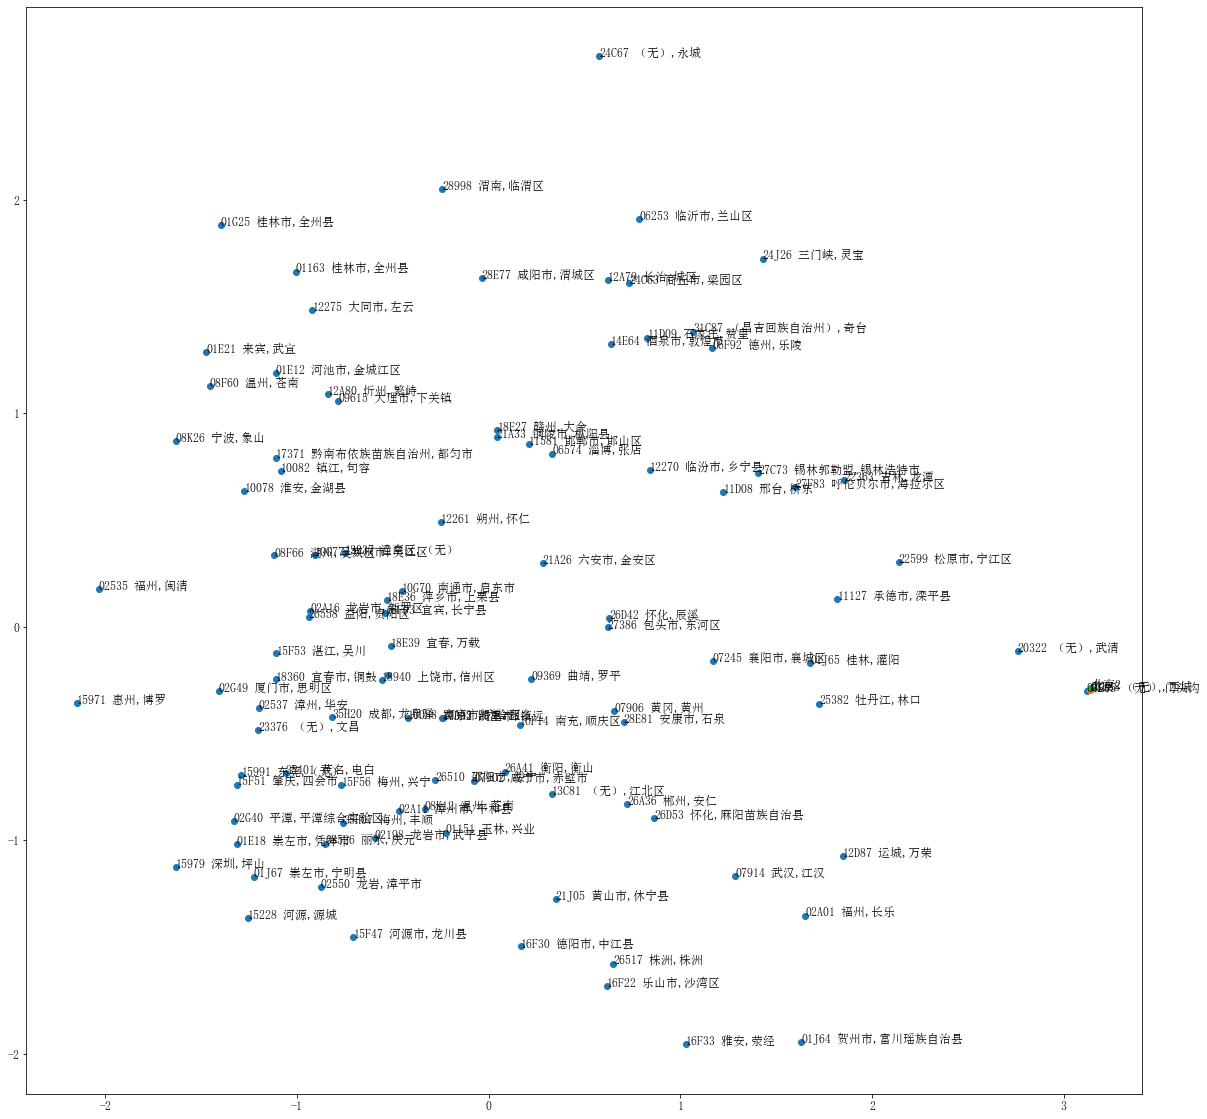

In [521]:
plt.rcParams['font.size'] = 12

plt.figure(figsize=(20, 20))
plt.scatter(dialect_pc[:, 0], dialect_pc[:, 1])
for i in range(dialect_pc.shape[0]):
    try:
        id = encoder.dialects[i].numpy().decode()
        plt.annotate(id + ' ' + location.loc[id, 'city'] + ',' + location.loc[id, 'country'], xy=(dialect_pc[i, 0], dialect_pc[i, 1]))
    except:
        pass

i = encoder.dialect_to_id(tf.constant(['03E88']))
plt.scatter(dialect_pc[i, 0], dialect_pc[i, 1])
plt.annotate('北京', xy=(dialect_pc[i[0], 0], dialect_pc[i[0], 1]))

i = encoder.dialect_to_id(tf.constant(['03E88_2']))
plt.scatter(dialect_pc[i, 0], dialect_pc[i, 1])
plt.annotate('北京2', xy=(dialect_pc[i[0], 0], dialect_pc[i[0], 1]))

plt.show()

In [539]:
dist = np.sqrt(np.sum(np.square(dialect_emb[:-1, None, :] - dialect_emb[None, :-1, :]), axis=2))
idx = np.argsort(dist, axis=1)[:, :10]
display(location.loc[np.char.decode(encoder.id_to_dialect(idx[0]).numpy().astype(np.bytes_))])

,longitude,latitude,insertDate,uploader,firstLevelid,sheetName,filepath,province,city,country,...,nation,minorityInfo,dialectInfo,operaInfo,source,degree,area,slice,slices,geometry
02A11,117.225000,24.158333,NaN,NaN,02A11,NaN,福建/平和客家话需交文件电子版/模板表/其他/概况.xls,福建,漳州市,平和县,...,汉族4.8万,（无）,平和县辖10个镇、5个乡：小溪镇、九峰镇、山格镇、南胜镇、文峰镇、坂仔镇、大溪镇、霞寨镇、芦...,潮剧,yubao,common,客家话,汀州片,平和小片,POINT (117.22500 24.15833)
35H07,116.725000,23.983333,NaN,NaN,35H07,NaN,濒危方言/广东梅州凤坪畲话需交文件电子版/模板表/其他/概况.xls,濒危方言,梅州,丰顺,...,多为汉族。畲族约500人。,（无）,客家话，分布在大多数乡镇。闽南话，主要分布在汤南、留隍两个镇。畲话，仅限于凤坪村。,丰顺山歌剧,yubao,endangered,NaN,NaN,NaN,POINT (116.72500 23.98333)
18940,117.920000,28.430000,NaN,NaN,18940,NaN,江西/上饶需交文件电子版/模板表/其他/概况.xls,江西,上饶市,信州区,...,汉族426129。,（无）,信州区通行的上饶话属吴语处衢片龙衢小片。中心城区所辖5个街道通行上饶街话，人口约28.3万，...,（无）,yubao,common,吴语,处衢片,龙衢小片,POINT (117.92000 28.43000)
15F47,115.320972,24.316667,NaN,NaN,15F47,NaN,广东/龙川需交文件电子版/模板表/其他/概况.xls,广东,河源市,龙川县,...,汉族，97.09万（2010年普查数据）,（无呈区域分布的少数民族语言）,龙川县全县通行客家话，学界把龙川县划到客家方言粤中片。龙川县内的客家话根据口音可以分为上半县...,有，客家山歌，普通市民比较喜爱唱山歌。龙川县山歌剧团是国营正规的专业艺术表演团体，艺术表演水...,yubao,common,客家方言,粤中,惠河,POINT (115.32097 24.31667)
02550,117.458333,25.341667,NaN,NaN,02550,NaN,福建/漳平需交文件电子版/模板表/其他/概况.xls,福建,龙岩,漳平市,...,据第四次人口普查（1990），畲族约1600人，占全县总人口0.6%；其他少数民族（回族、苗...,畲语，集中居住在桂林街道山羊，近两千人。,漳平境内的方言基本属于闽南方言，由于与通行客家话的闽西地区交界，在某些方面受客家话的明显影响...,一、受外来影响的汉剧和芗剧；二、畲族的盘歌对唱。,yubao,common,NaN,NaN,NaN,POINT (117.45833 25.34167)
01151,109.520000,22.450000,NaN,NaN,01151,NaN,广西/兴业石南话需交文件电子版/模板表/其他/0001调查点概况.xls,广西,玉林,兴业,...,壮族2万，汉族73万,有少数民族语言、壮族语言、分布在兴业县山心镇石柜村，约2000多人。,（1）城隍镇、石南镇、葵阳镇 22万人口、石南方言、日常交流、存在尾音差别。\n（2）山心镇...,鹩剧（有点像粤剧）有喜庆节日时用唱，有时也作乡村文化，到乡下唱。舞龙、舞狮、八音，红、白事都...,6fang,common,NaN,NaN,NaN,POINT (109.52000 22.45000)
18360,114.408333,28.600000,NaN,NaN,18360,NaN,江西/铜鼓需交文件电子版/模板表/其他/概况.xls,江西,宜春市,铜鼓,...,汉族138798,（无）,铜鼓县是客家之乡，铜鼓县人口的70%为客家人，是赣西北客家人聚居中心。客家话分布在铜鼓县大部...,铜鼓县最著名的曲艺项目是客家山歌。康熙年间，闽、粤、赣南一批客家人迁铜鼓后，客家山歌便在铜鼓...,yubao,common,NaN,NaN,NaN,POINT (114.40833 28.60000)
15F56,115.750000,24.225000,NaN,NaN,15F56,NaN,广东/兴宁需交文件电子版/模板表/其他/概况.xls,广东,梅州,兴宁,...,汉族118万,少数民族极少,大致分为两种：上山话，主要包括罗岗、罗浮、大坪、岗背、黄槐等乡镇；下山话，其他乡镇（含城区）...,主要是杯花舞、马灯舞、竹板歌和客家山歌。,yubao,common,客家话,粤台片,梅惠小片,POINT (115.75000 24.22500)
26A53,112.510520,27.771650,NaN,NaN,26A53,NaN,湖南/湘乡需交文件电子版/模板表/其他/概况.xls,湖南,湘潭,湘乡,...,主要是汉族，少数民族只有两百多人。,（无）,本县只一种汉语方言，大致可分为四片。一、城关、泉塘、东郊、白田、潭市、中沙、龙洞、育塅、虞唐...,（无）,yubao,common,湘,娄邵片,湘双,POINT (112.51052 27.77165)
02537,117.530000,25.000000,NaN,NaN,02537,NaN,福建/华安需交文件电子版/模板表/其他/概况.xls,福建,漳州,华安,...,汉族400154；满族21172；回族4155；蒙古族555；壮族196。,（无）,以闽南话为主。部分畲族使用客家话。,芗剧,yubao,common,NaN,NaN,NaN,POINT (117.53000 25.00000)


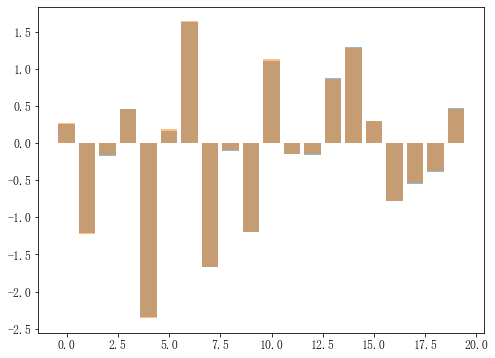

In [525]:
emb = encoder.get_dialect_emb(tf.convert_to_tensor(['03E88', '03E88_2']))
beijing_emb = emb[0]
beijing2_emb = emb[1]

plt.figure(figsize=(8, 6))
plt.bar(np.arange(emb_size), beijing_emb, alpha=0.5)
plt.bar(np.arange(emb_size), beijing2_emb, alpha=0.5)
plt.show()

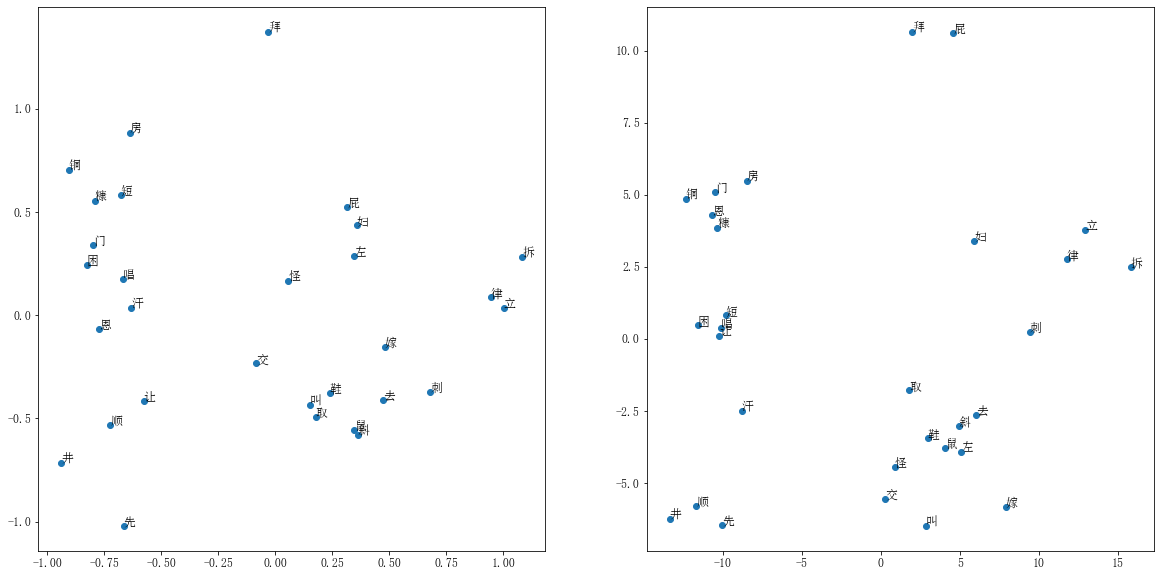

In [524]:
char_emb = encoder.char_emb.numpy()
dest_emb = encoder.transform(tf.tile(encoder.get_dialect_emb(tf.convert_to_tensor(['03E88'])), [char_emb.shape[0], 1]), char_emb).numpy()
char_pca = PCA(2).fit(char_emb)
dest_pca = PCA(2).fit(dest_emb)

idx = np.random.choice(char_emb.shape[0] - 1, 30, replace=False)
char_ids = encoder.id_to_char(idx).numpy().astype(np.bytes_).astype(int)
chars = char.loc[char_ids, 'item'].values
char_pc = char_pca.transform(char_emb[idx])
dest_pc = dest_pca.transform(dest_emb[idx])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

ax1.scatter(char_pc[:, 0], char_pc[:, 1])
for i in range(char_pc.shape[0]):
    ax1.annotate(chars[i], xy=(char_pc[i, 0], char_pc[i, 1]))
    
ax2.scatter(dest_pc[:, 0], dest_pc[:, 1])
for i in range(dest_pc.shape[0]):
    ax2.annotate(chars[i], xy=(dest_pc[i, 0], dest_pc[i, 1]))
    
plt.show()

In [540]:
char_emb = encoder.char_emb.numpy()
dist = np.sqrt(np.sum(np.square(char_emb[:-1, None, :] - char_emb[None, :-1, :]), axis=2))
idx = np.argsort(dist, axis=1)[:, :10]
display(char.loc[encoder.id_to_char(idx[0]).numpy().astype(int)])

,item,memo
cid,,
1,多,NaN
2,拖,NaN
17,躲,NaN
65,杜,NaN
461,单,简～
557,端,～午
280,刀,NaN
70,错,对～
283,道,NaN


In [556]:
cemb = encoder.get_char_emb(['0280', '0282', '0917', '0923'])
new_cemb = cemb[0] - cemb[1] + cemb[3]
idx = np.argsort(np.sum(np.square(char_emb[:-1] - new_cemb), axis=1))[:10]
display(char.loc[encoder.id_to_char(idx).numpy().astype(int)])

,item,memo
cid,,
665,墩,NaN
917,东,NaN
943,冬,～至
557,端,～午
669,蹲,注意声
918,懂,NaN
920,通,NaN
558,短,NaN
919,冻,NaN


In [526]:
initial_emb = tf.math.l2_normalize(encoder.output_embs[0], axis=0).numpy().T
final_emb = tf.math.l2_normalize(encoder.output_embs[1], axis=0).numpy().T
tone_emb = tf.math.l2_normalize(encoder.output_embs[2], axis=0).numpy().T

pca = PCA(2).fit(np.concatenate([initial_emb, final_emb, tone_emb], axis=0))
initial_pc = pca.transform(initial_emb)
final_pc = pca.transform(final_emb)
tone_pc = pca.transform(tone_emb)

In [601]:
test_dialects = ['03E88', '15228']
test_chars = ['0469', '0474', '0656']
demb = encoder.get_dialect_emb(test_dialects)
cemb = encoder.get_char_emb(test_chars)
emb = encoder.transform(tf.repeat(demb, cemb.shape[0], axis=0), tf.tile(cemb, [demb.shape[0], 1]))
new_emb = emb[0::3] - emb[1::3] + emb[2::3]
pred = np.char.decode(tf.stack(
    [encoder.id_to_target(i, tf.argmax(tf.matmul(new_emb, e), axis=1)) for i, e in enumerate(encoder.output_embs)]
    , axis=1
).numpy().astype(np.bytes_))
display(pred)

array([['tɕ', 'i', '55'],
       ['k', 'it', '5']], dtype='<U2')

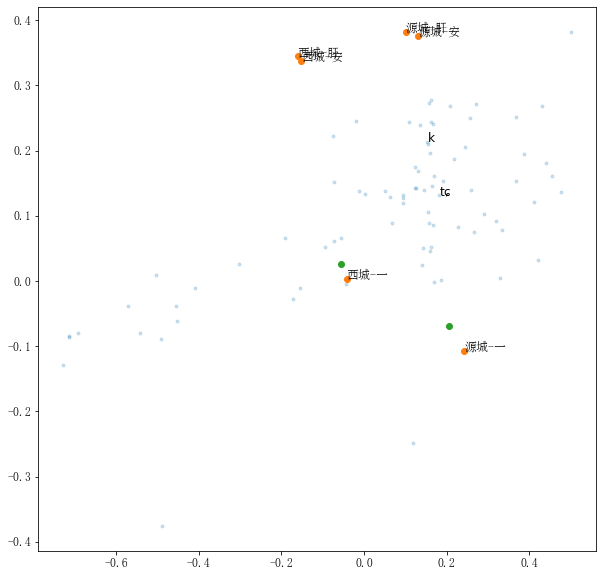

In [606]:
plt.figure(figsize=(10, 10))
plt.scatter(initial_pc[:, 0], initial_pc[:, 1], marker='.', alpha=0.2)
# plt.scatter(final_pc[:, 0], final_pc[:, 1], marker='.', alpha=0.2)
# plt.scatter(tone_pc[:, 0], tone_pc[:, 1], marker='.', alpha=0.2)
pc = pca.transform(tf.linalg.normalize(emb, axis=1)[0])
new_pc = pca.transform(tf.linalg.normalize(new_emb, axis=1)[0])
plt.scatter(pc[:, 0], pc[:, 1])
plt.scatter(new_pc[:, 0], new_pc[:, 1])

for i in range(pc.shape[0]):
    plt.annotate(
        '{}-{}'.format(location.loc[test_dialects[i // 3], 'country'], char.loc[int(test_chars[i % 3]), 'item']),
        xy=(pc[i, 0], pc[i, 1])
    )
    
initial_id = encoder.target_to_id(0, pred[:, 0]).numpy()
for i in range(initial_id.shape[0]):
    plt.annotate(r'$\mathrm{{{}}}$'.format(pred[i, 0]), xy=(initial_pc[i, 0], initial_pc[i, 1]))
    
plt.show()

In [527]:
demb = encoder.get_dialect_emb(['03E88', '08F66'])
demb1 = demb[0]
demb2 = demb[1]
cemb = encoder.get_char_emb(['0843'])[0]
w = np.arange(0, 1.1, 0.1)
demb = (1 - w[:, None]) * demb1[None, :] + w[:, None] * demb2[None, :]
emb = encoder.transform(demb, tf.tile(cemb[None, :], [demb.shape[0], 1]))
pred = encoder.predict_id_emb(demb, tf.tile(cemb[None, :], [demb.shape[0], 1]))

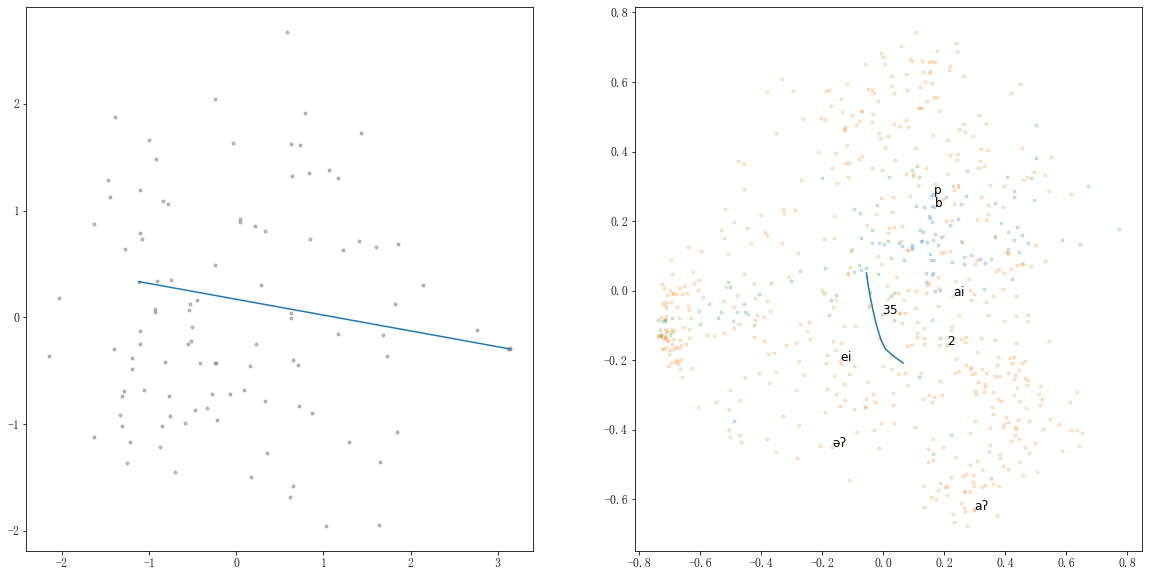

In [528]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

ax1.scatter(dialect_pc[:, 0], dialect_pc[:, 1], marker='.', color='gray', alpha=0.5)
src_pc = dialect_pca.transform(demb.numpy())
ax1.plot(src_pc[:, 0], src_pc[:, 1])

ax2.scatter(initial_pc[:, 0], initial_pc[:, 1], marker='.', alpha=0.2)
ax2.scatter(final_pc[:, 0], final_pc[:, 1], marker='.', alpha=0.2)
ax2.scatter(tone_pc[:, 0], tone_pc[:, 1], marker='.', alpha=0.2)
dest_pc = pca.transform(tf.math.l2_normalize(emb, axis=1).numpy())
ax2.plot(dest_pc[:, 0], dest_pc[:, 1])

for i, pc in enumerate([initial_pc, final_pc, tone_pc]):
    ids = tf.unique(pred[:, i])[0]
    phones = np.char.decode(encoder.id_to_target(i, ids).numpy().astype(np.bytes_))
    for id, phone in zip(ids.numpy(), phones):
        ax2.annotate(r'$\mathrm{{{}}}$'.format(phone), xy=(pc[id, 0], pc[id, 1]))
    
plt.show()

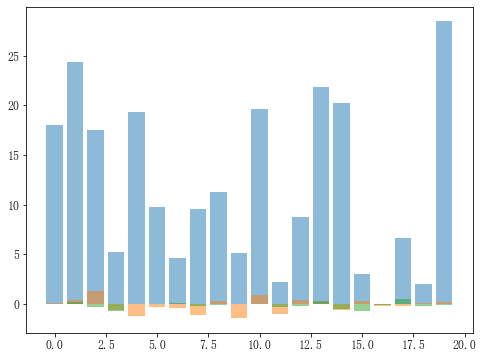

In [529]:
plt.figure(figsize=(8, 6))
plt.bar(np.arange(emb_size), emb[0], alpha=0.5)
plt.bar(np.arange(emb_size), tf.nn.embedding_lookup(tf.transpose(encoder.output_embs[0]), encoder.target_to_id(0, tf.convert_to_tensor(['p'])))[0], alpha=0.5)
plt.bar(np.arange(emb_size), tf.nn.embedding_lookup(tf.transpose(encoder.output_embs[1]), encoder.target_to_id(1, tf.convert_to_tensor(['ai'])))[0], alpha=0.5)
# plt.bar(np.arange(emb_size), tf.nn.embedding_lookup(tf.transpose(encoder.output_embs[2]), encoder.target_to_id(2, tf.convert_to_tensor(['35'])))[0], alpha=0.5)
plt.show()

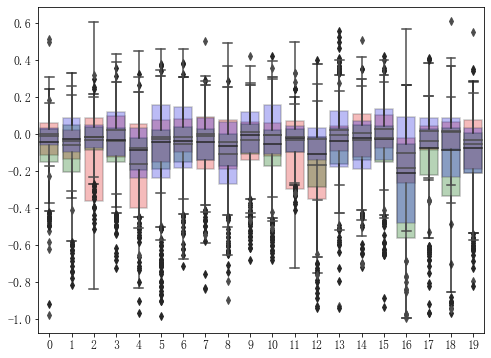

In [530]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=initial_emb, color='red', boxprops={'alpha': 0.3})
sns.boxplot(data=final_emb, color='green', boxprops={'alpha': 0.3})
sns.boxplot(data=tone_emb, color='blue', boxprops={'alpha': 0.3})
plt.show()

In [37]:
oe = OrdinalEncoder(dtype=np.int32)
codes = oe.fit_transform(data[['oid', 'iid', 'initial', 'finals', 'tone']])

In [344]:
train_data, test_data = train_test_split(codes, test_size=0.1)

In [347]:
model = make_model(
    oe.categories_[0].shape[0],
    oe.categories_[1].shape[0],
    [oe.categories_[2].shape[0], oe.categories_[3].shape[0], oe.categories_[4].shape[0]],
    dialect_emb_size=20,
    char_emb_size=20
)
model.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dialect_id (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
char_id (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
dialect_emb (Embedding)         (None, 20)           2040        dialect_id[0][0]                 
__________________________________________________________________________________________________
char_emb (Embedding)            (None, 20)           20000       char_id[0][0]                    
____________________________________________________________________________________________

In [359]:
model.fit(
    [train_data[:, 0], train_data[:, 1]],
    [train_data[:, 2], train_data[:, 3], train_data[:, 4]],
    epochs=20,
    batch_size=100
)

Epoch 1/20
961/961 [==============================] - 3s 3ms/step - loss: 1.7210 - dense_92_loss: 0.3936 - dense_93_loss: 0.7019 - dense_94_loss: 0.3114 - dense_92_accuracy: 0.8777 - dense_93_accuracy: 0.7918 - dense_94_accuracy: 0.9121
Epoch 2/20
961/961 [==============================] - 3s 3ms/step - loss: 1.7133 - dense_92_loss: 0.3906 - dense_93_loss: 0.6992 - dense_94_loss: 0.3105 - dense_92_accuracy: 0.8762 - dense_93_accuracy: 0.7910 - dense_94_accuracy: 0.9136A: 1s - loss: 1.6963 - dense_92_loss: 0.3857 - dense_93_loss: 0.6875 - dense_94_loss: 0.3096 - dense_92_accuracy: 0.8773 - dense_93_accuracy: 0.7931 - dense_94_accuracy: 0.9 - ETA: 1s - loss: 1.7004 - dense_92_loss: 0.3860 - dense_93_loss: 0.6910 - dense_94_loss: 0.3100 - dense_92_accuracy: 0.8772 - dense_93_accuracy: 0.7924 - den
Epoch 3/20
961/961 [==============================] - 3s 3ms/step - loss: 1.7000 - dense_92_loss: 0.3904 - dense_93_loss: 0.6897 - dense_94_loss: 0.3075 - dense_92_accuracy: 0.8770 - dense_93_ac

In [360]:
model.evaluate(
    [test_data[:, 0], test_data[:, 1]],
    [test_data[:, 2], test_data[:, 3], test_data[:, 4]]
)

334/334 [==============================] - 1s 1ms/step - loss: 1.7732 - dense_92_loss: 0.4004 - dense_93_loss: 0.7494 - dense_94_loss: 0.3212 - dense_92_accuracy: 0.8772 - dense_93_accuracy: 0.7873 - dense_94_accuracy: 0.9112A: 0s - loss: 1.7613 - dense_92_loss: 0.4018 - dense_93_loss: 0.7398 - dense_94_loss: 0.3174 - dense_92_accuracy: 0.8789 - dense_93_accuracy: 0.7866 - dense_94_accuracy: 0


[1.773205041885376,
 0.40044912695884705,
 0.7493739724159241,
 0.3211662471294403,
 0.8772143721580505,
 0.787327766418457,
 0.9112381935119629]

In [361]:
dialect_emb = model.get_layer('dialect_emb').get_weights()[0]
dialect_pc = PCA(2).fit_transform(dialect_emb)

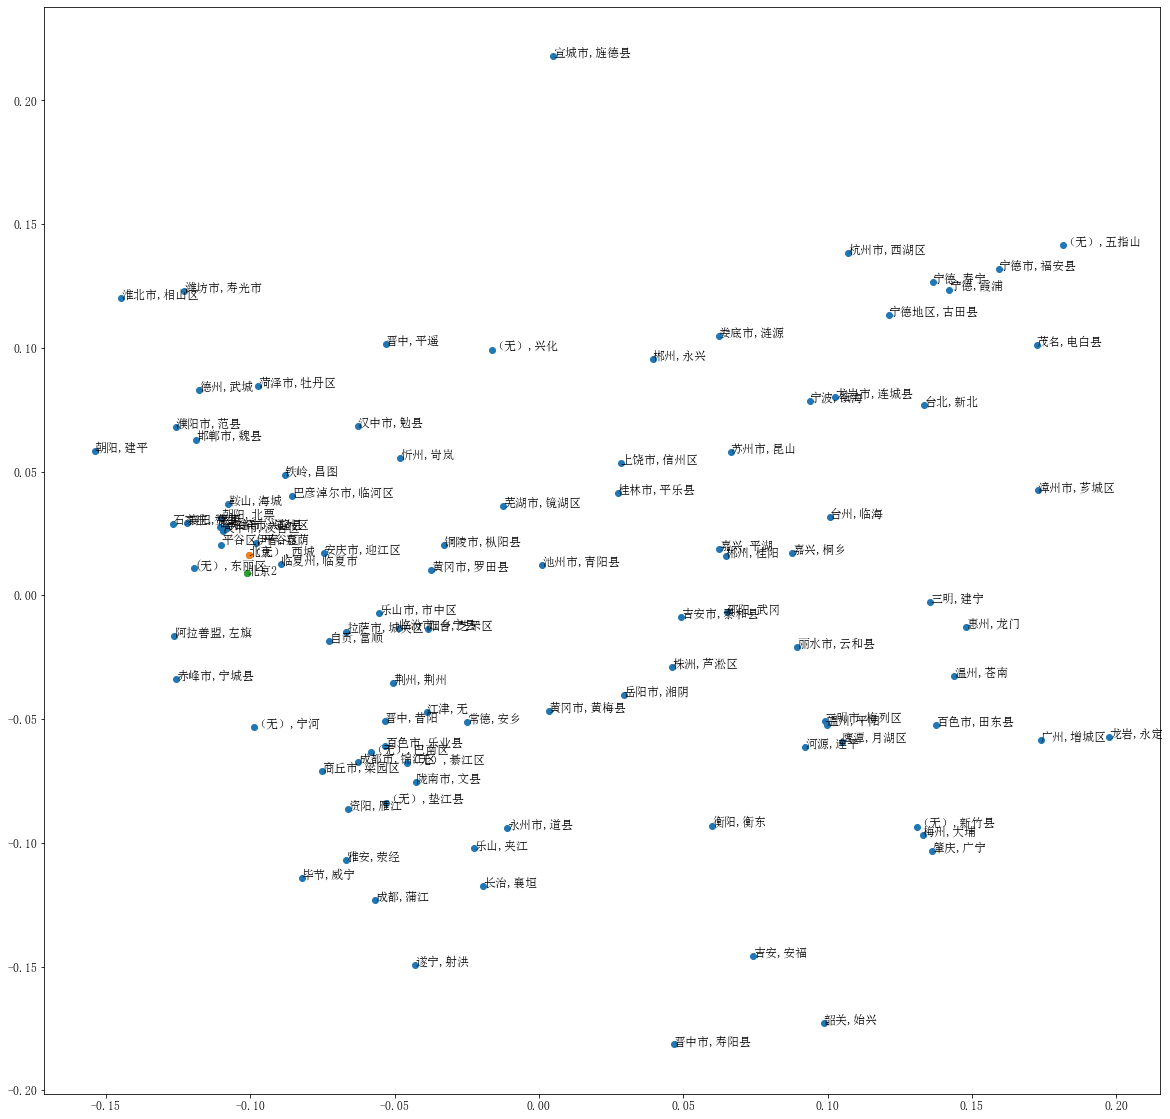

In [362]:
# idx = np.random.choice(dialect_pc.shape[0], 200, replace=False)
idx = np.arange(dialect_pc.shape[0])

plt.rcParams['font.size'] = 12

plt.figure(figsize=(20, 20))
plt.scatter(dialect_pc[idx, 0], dialect_pc[idx, 1])
for i in idx:
    id = oe.categories_[0][i]
    try:
        plt.annotate(location.loc[id, 'city'] + ',' + location.loc[id, 'country'], xy=(dialect_pc[i, 0], dialect_pc[i, 1]))
    except:
        pass
    
i = np.argwhere(oe.categories_[0] == '03E88')[0]
plt.scatter(dialect_pc[i, 0], dialect_pc[i, 1])
plt.annotate('北京', xy=(dialect_pc[i[0], 0], dialect_pc[i[0], 1]))

i = np.argwhere(oe.categories_[0] == '03E88_2')[0]
plt.scatter(dialect_pc[i, 0], dialect_pc[i, 1])
plt.annotate('北京2', xy=(dialect_pc[i[0], 0], dialect_pc[i[0], 1]))

plt.show()

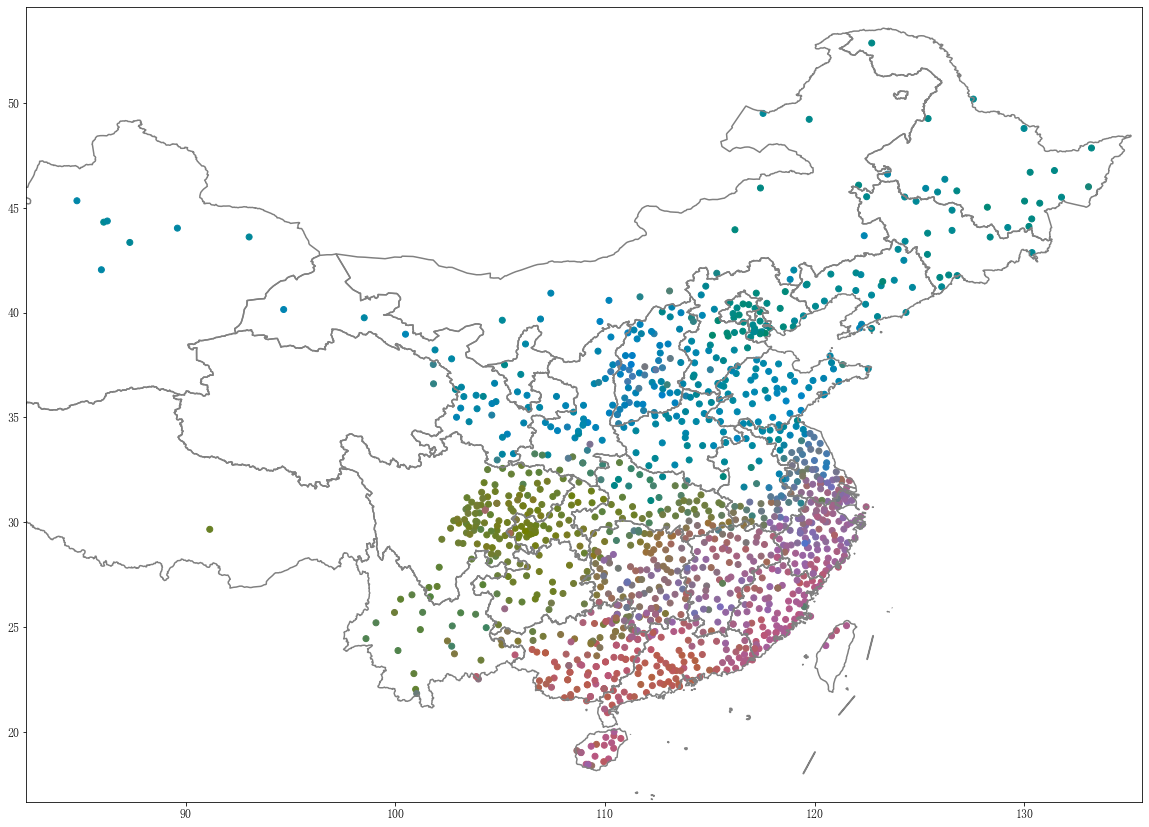

In [217]:
similarity.plot_map(china, location.loc[oe.categories_[0]], pc=dialect_pc, figsize=(20, 20))
plt.show()

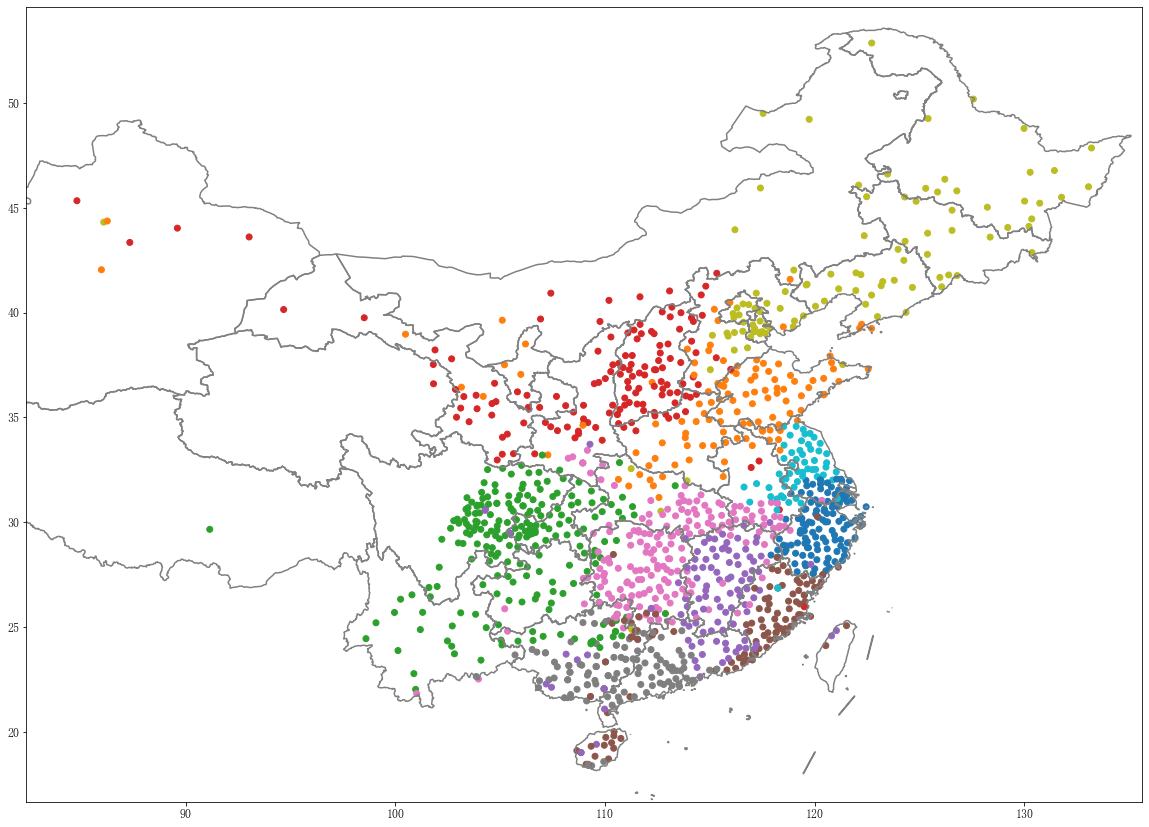

In [216]:
labels = KMeans(n_clusters=10).fit_predict(dialect_emb)
similarity.plot_map(china, location.loc[oe.categories_[0]], column=labels, figsize=(20, 20), cmap='tab10')
plt.show()

In [219]:
labels = SpectralClustering(n_clusters=10).fit_predict(dialect_emb)
similarity.plot_map(china, location.loc[oe.categories_[0]], column=labels, figsize=(20, 20), cmap='tab10')
plt.show()

KeyboardInterrupt: 

In [220]:
char_emb = model.get_layer('char_emb').get_weights()[0]
char_pc = PCA(2).fit_transform(char_emb)

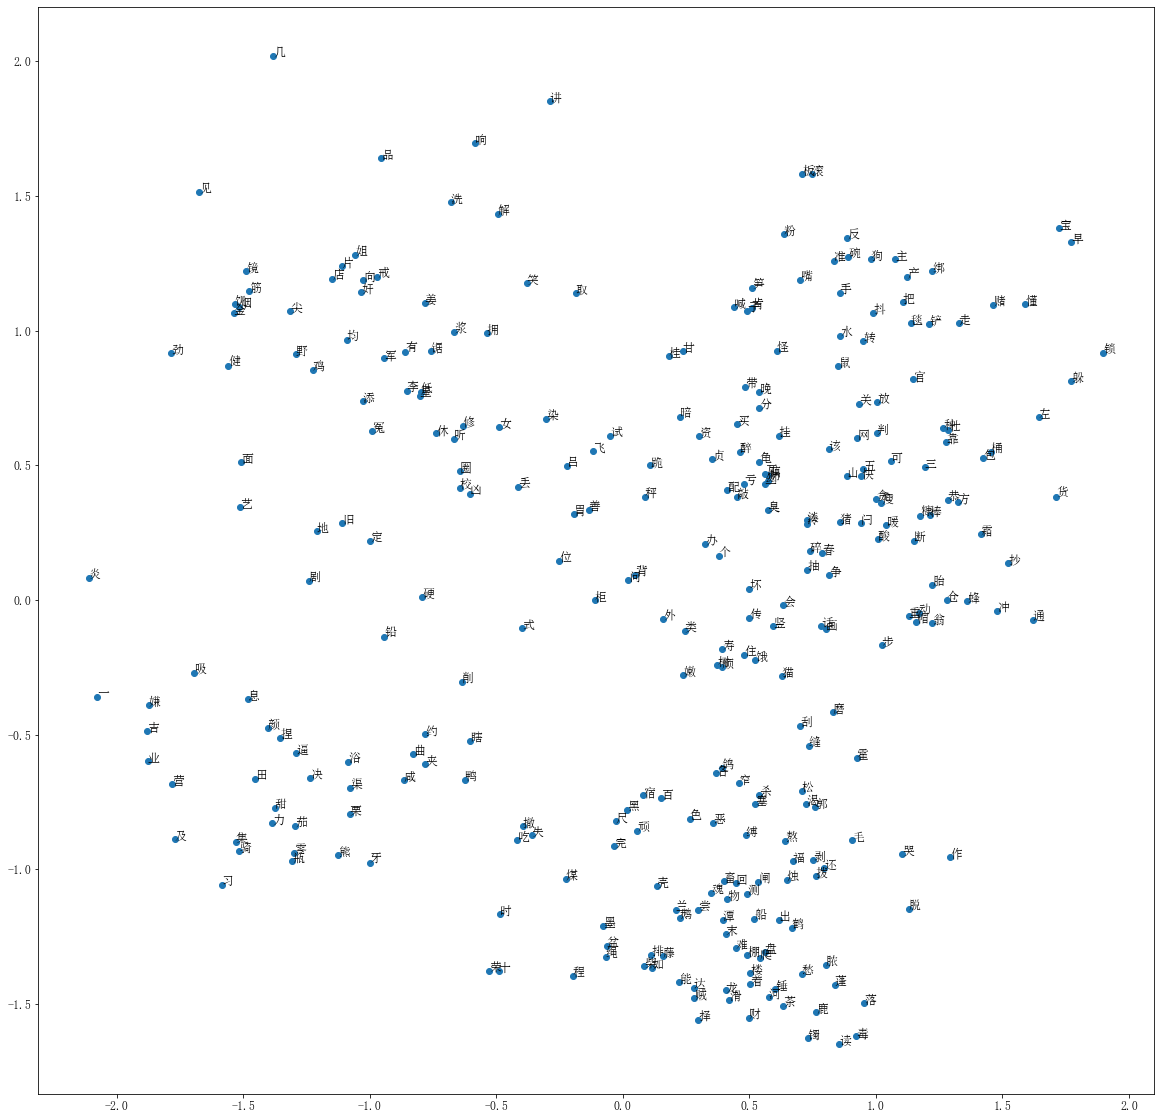

In [222]:
idx = np.random.choice(char_pc.shape[0], 300, replace=False)

plt.rcParams['font.size'] = 12

plt.figure(figsize=(20, 20))
plt.scatter(char_pc[idx, 0], char_pc[idx, 1])
for i in idx:
    try:
        plt.annotate(char.loc[int(oe.categories_[1][i]), 'item'], xy=(char_pc[i, 0], char_pc[i, 1]))
    except:
        pass
plt.show()

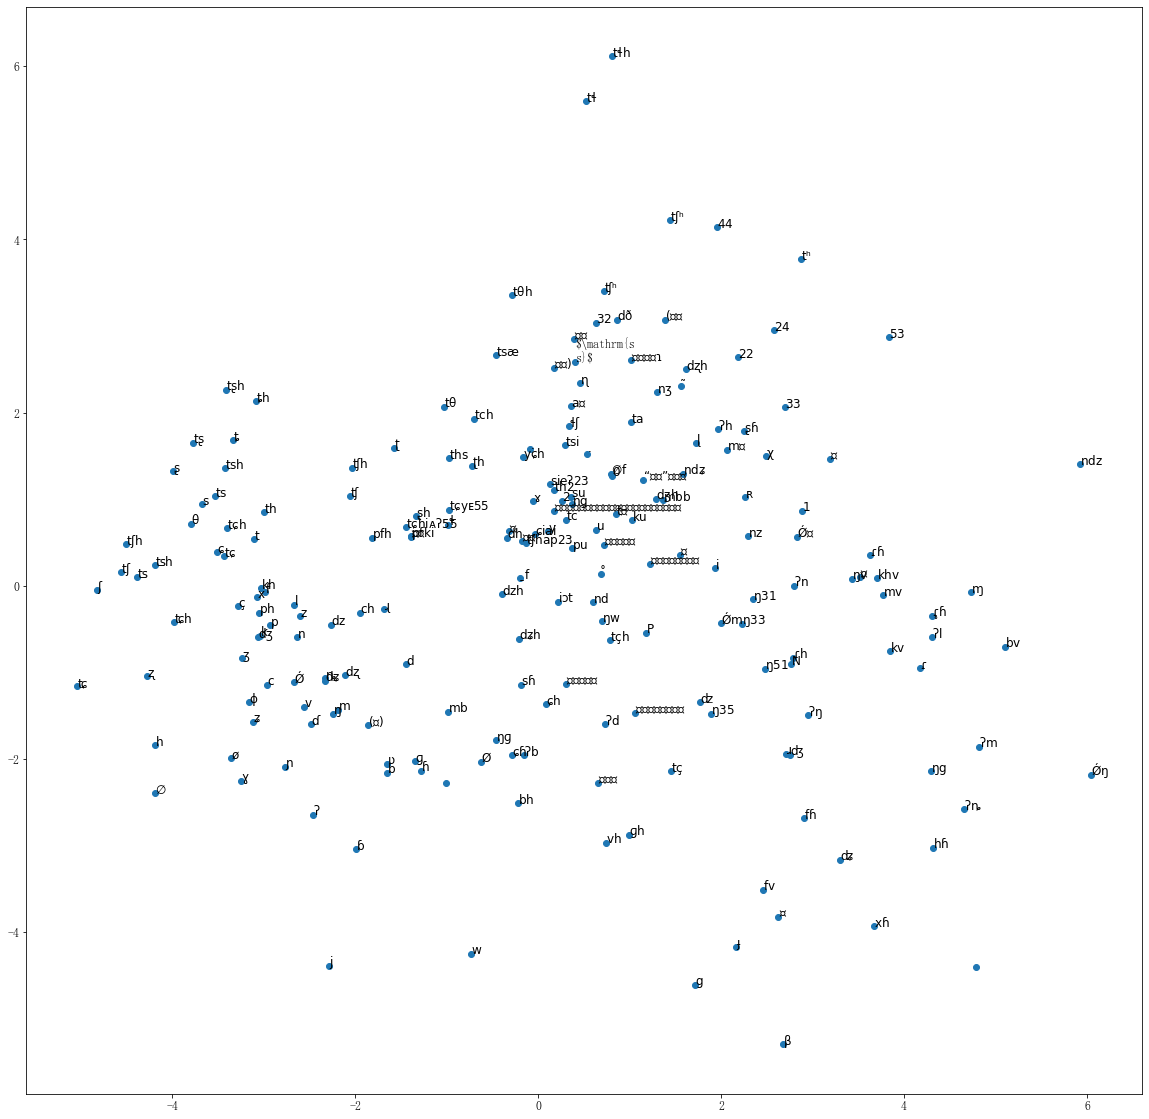

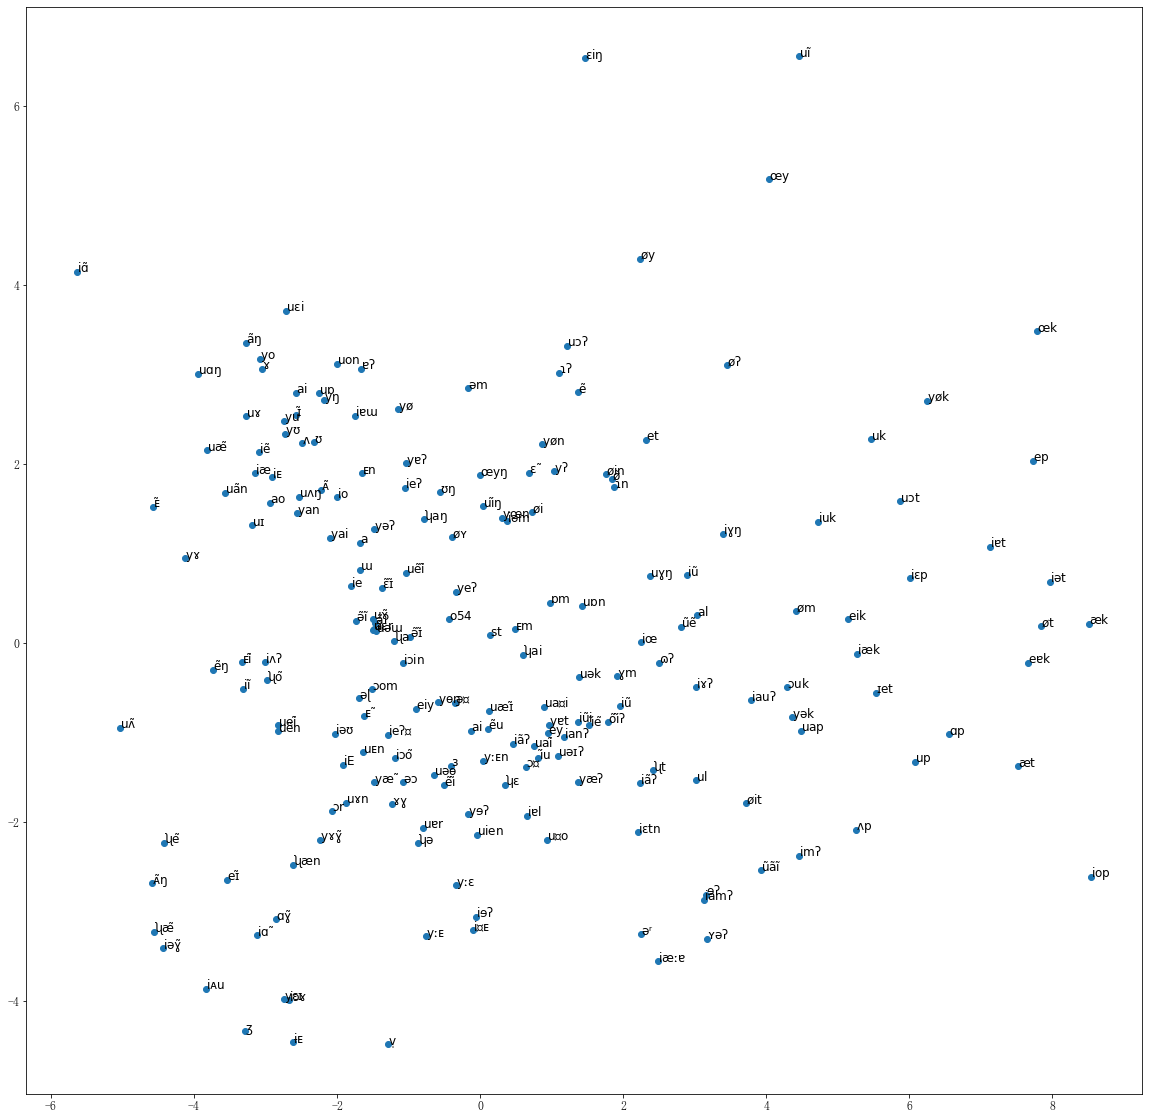

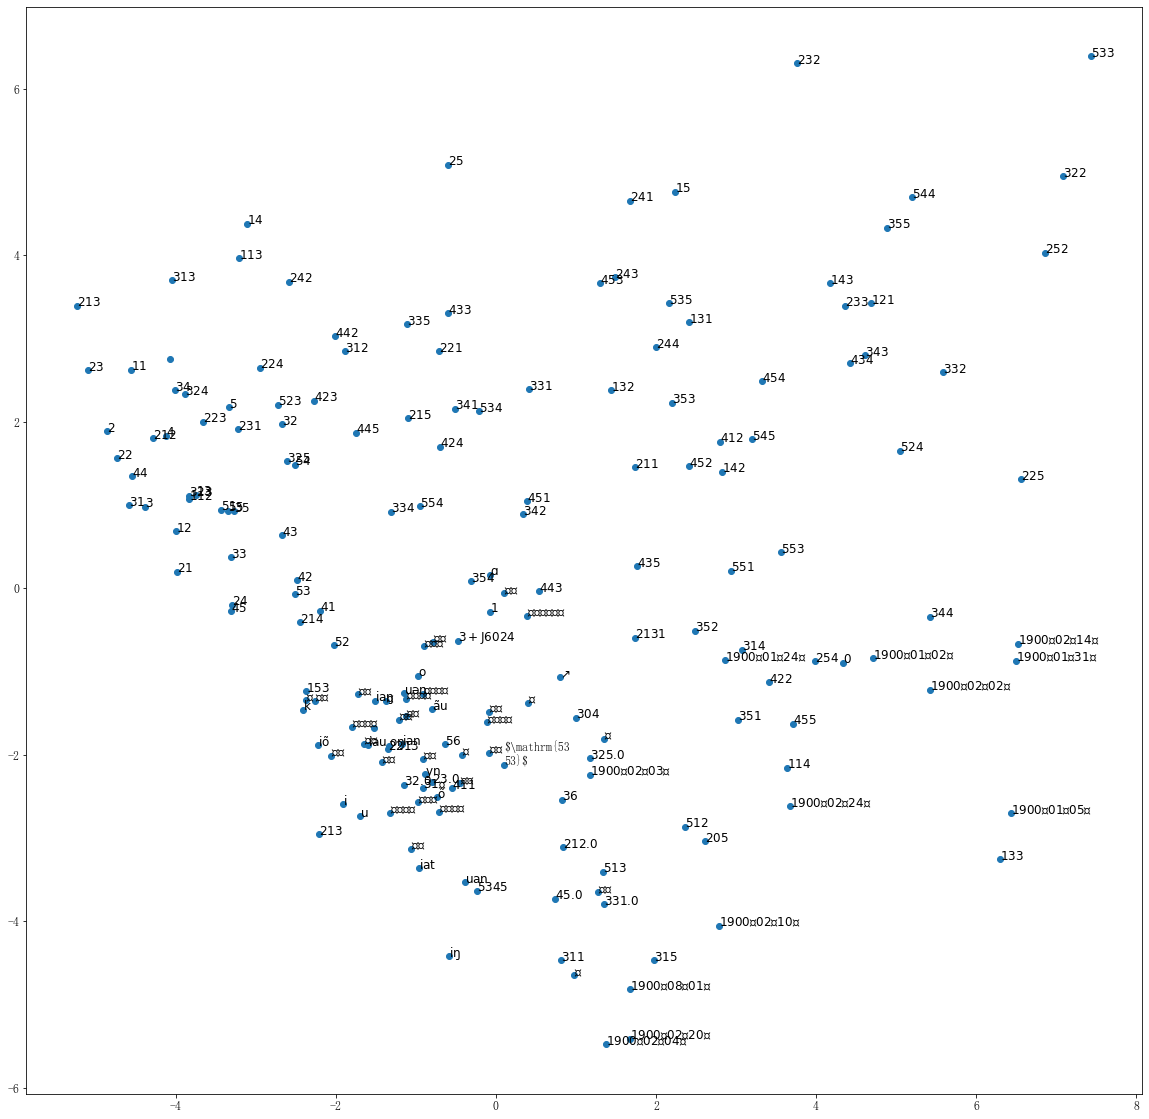

In [243]:
initial_emb = model.get_layer('dense_67').get_weights()[0].T
final_emb = model.get_layer('dense_68').get_weights()[0].T
tone_emb = model.get_layer('dense_69').get_weights()[0].T

initial_pc = PCA(2).fit_transform(initial_emb)
final_pc = PCA(2).fit_transform(final_emb)
tone_pc = PCA(2).fit_transform(tone_emb)

plt.rcParams['font.size'] = 12

plt.figure(figsize=(20, 20))
plt.scatter(initial_pc[:, 0], initial_pc[:, 1])
for i, initial in enumerate(oe.categories_[2]):
    plt.annotate(r'$\mathrm{{{}}}$'.format(initial), xy=(initial_pc[i, 0], initial_pc[i, 1]))
plt.show()

idx = np.random.choice(oe.categories_[3].shape[0], 200, replace=False)

plt.figure(figsize=(20, 20))
plt.scatter(final_pc[idx, 0], final_pc[idx, 1])
for i in idx:
    plt.annotate(r'$\mathrm{{{}}}$'.format(oe.categories_[3][i]), xy=(final_pc[i, 0], final_pc[i, 1]))
plt.show()

plt.figure(figsize=(20, 20))
plt.scatter(tone_pc[:, 0], tone_pc[:, 1])
for i, tone in enumerate(oe.categories_[4]):
    plt.annotate(r'$\mathrm{{{}}}$'.format(tone), xy=(tone_pc[i, 0], tone_pc[i, 1]))
plt.show()

In [273]:
beijing_emb = dialect_emb[np.argwhere(oe.categories_[0] == '03E88')[0, 0]]
changping_emb = dialect_emb[np.argwhere(oe.categories_[0] == '03E82')[0, 0]]
harbin_emb = dialect_emb[np.argwhere(oe.categories_[0] == '25381')[0, 0]]
guangzhou_emb = dialect_emb[np.argwhere(oe.categories_[0] == '15231')[0, 0]]
wuzhou_emb = dialect_emb[np.argwhere(oe.categories_[0] == '01G27')[0, 0]]

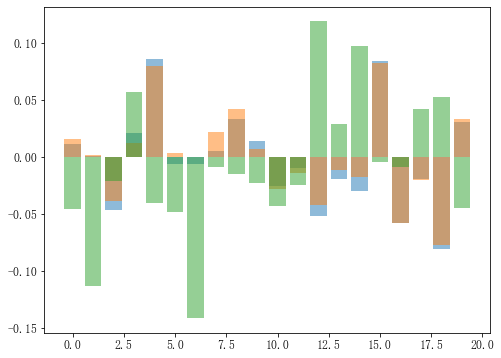

In [367]:
beijing_emb = dialect_emb[np.argwhere(oe.categories_[0] == '03E88')[0, 0]]
beijing2_emb = dialect_emb[np.argwhere(oe.categories_[0] == '03E88_2')[0, 0]]
zengcheng_emb = dialect_emb[np.argwhere(oe.categories_[0] == '15237')[0, 0]]

plt.figure(figsize=(8, 6))
plt.bar(np.arange(beijing_emb.shape[0]), beijing_emb, alpha=0.5)
plt.bar(np.arange(beijing2_emb.shape[0]), beijing2_emb, alpha=0.5)
plt.bar(np.arange(zengcheng_emb.shape[0]), zengcheng_emb, alpha=0.5)
plt.show()